## **Câu 5: Recommendation - Amazon - Office Products (1.0 điểm)**
Use the information "reviewerID", "asin" (ProductID), and “overall” (users’ 
ratings for each product) in dataset Office_Products_5.json (unzip file
reviews_Office_Products_5.json.gz) to build a model to predict overalls for 
products that have not been selected by users. Then make recommendations 
to some users: A3CJ7MHAS9IMAM, A3LGT6UZL99IW1, A21KNRUAA5RK5E


**Data understanding**
Data Collection
Datasets contain product review on Amazon from May,1996 to July, 2014.
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
!tar xf spark-3.1.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
import pyspark
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml.feature import CountVectorizer,IDF,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

from scipy import stats
from datetime import datetime
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer, OneHotEncoder, Bucketizer, VectorAssembler, StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import round

from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import when

from pyspark.ml.linalg import Vectors


In [46]:
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import iqr
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from scipy.stats import iqr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky


In [8]:
from pyspark import SparkContext
sc = SparkContext()


In [9]:
spark = SparkSession(sc)

In [13]:
df = spark.read.json('data/Office_Products_5.json')


### **Phân tích khai phá dữ liệu và tiền xử lý (EDA & Preprocessing)**

In [14]:
df.show(10)

+----------+--------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------+
|B00000JBLH|  [3, 4]|    5.0|I bought my first...| 09 3, 2004|A32T2H8150OJLU|                ARH|A solid performer...|    1094169600|
|B00000JBLH|  [7, 9]|    5.0|WHY THIS BELATED ...|12 15, 2007|A3MAFS04ZABRGO|   Let it Be "Alan"|Price of GOLD is ...|    1197676800|
|B00000JBLH|  [3, 3]|    2.0|I have an HP 48GX...| 01 1, 2011|A1F1A0QQP2XVH5|             Mark B|Good functionalit...|    1293840000|
|B00000JBLH|  [7, 8]|    5.0|I've started doin...|04 19, 2006| A49R5DBXXQDE5|       R. D Johnson|One of the last o...|    1145404800|
|B00000JBLH|  [0, 0]|    5.0|For simple calcul...| 08 4, 2013|

In [17]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [18]:
df.describe().show()

+-------+----------+------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|summary|      asin|           overall|          reviewText|reviewTime|          reviewerID|        reviewerName|             summary|      unixReviewTime|
+-------+----------+------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|  count|     53258|             53258|               53258|     53258|               53258|               52799|               53258|               53258|
|   mean|      null| 4.345957414848473|                null|      null|                null|               319.0|                null|1.3400844165383604E9|
| stddev|      null|0.9302498738235792|                null|      null|                null|                 0.0|                null| 5.266063365635001E7|
|    min|B00000JBLH|               1.0|                    |01 1

In [20]:
rating = df.select(['asin', 'overall', 'reviewerID'])

In [21]:
rating.show(5)

+----------+-------+--------------+
|      asin|overall|    reviewerID|
+----------+-------+--------------+
|B00000JBLH|    5.0|A32T2H8150OJLU|
|B00000JBLH|    5.0|A3MAFS04ZABRGO|
|B00000JBLH|    2.0|A1F1A0QQP2XVH5|
|B00000JBLH|    5.0| A49R5DBXXQDE5|
|B00000JBLH|    5.0|A2XRMQA6PJ5ZJ8|
+----------+-------+--------------+
only showing top 5 rows



In [22]:
rating.count()

53258

### **Clean Data**

### **Check missing data**

In [23]:
rating.select([count(when(isnan(c), c)).alias(c) for c in rating.columns]).toPandas().T

,0
asin,0
overall,0
reviewerID,0


In [24]:
rating.select([count(when(col(c).isNull(), c)).alias(c) for c in rating.columns]).toPandas().T

,0
asin,0
overall,0
reviewerID,0


Không có null và nan

### **Check duplicates**

In [25]:
total = rating.count()
distinct = rating.distinct().count()

print('df', 'có', total, 'records')
print('df', 'có', distinct, 'distinct records')
if total > distinct:
    print('df', 'có các duplicate records với ' + str(total - distinct) + ' duplicate records')
else:
    print('df', 'ko có duplicate records')

df có 53258 records
df có 53258 distinct records
df ko có duplicate records


In [26]:
rating.columns

['asin', 'overall', 'reviewerID']

### **Phân tích các biến**

**overall**

In [28]:
def categorical_univariate_variable(f):
    print("1\ Mật độ phân phối: \n", f.value_counts())
    print("2\ Số giá trị NaN: \n", f.isnull().sum())
    print("\n\n3\ Tỉ lệ mật độ phân phối:\n", f.value_counts() / len(f))
    f.value_counts().plot.bar()
    plt.show()

In [29]:
rating_pd = rating.toPandas()

1\ Mật độ phân phối: 
 5.0    30327
4.0    15015
3.0     5060
2.0     1726
1.0     1130
Name: overall, dtype: int64
2\ Số giá trị NaN: 
 0


3\ Tỉ lệ mật độ phân phối:
 5.0    0.569436
4.0    0.281929
3.0    0.095009
2.0    0.032408
1.0    0.021217
Name: overall, dtype: float64


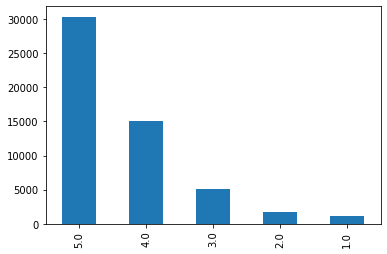

In [31]:
categorical_univariate_variable(rating_pd.overall)

In [32]:
'''
Nhìn chung thì overral = 5 chiếm đa số
'''

'\nNhìn chung thì overral = 5 chiếm đa số\n'

**reviewerID, asin**
- đây là các biến định danh

## **Data Transformation**


In [33]:
# asin và reviewerID cần chuyển đổi thành StringIndexer cho prediction model.
indexer = StringIndexer(inputCol = 'asin', outputCol = 'asin_idx')
indexer1 = StringIndexer(inputCol = 'reviewerID', outputCol = 'reviewID_idx')

In [34]:
pipeline = Pipeline(stages = [indexer, indexer1])

In [35]:
data_indexed = pipeline.fit(rating).transform(rating)


In [36]:
data_indexed.show(5)


+----------+-------+--------------+--------+------------+
|      asin|overall|    reviewerID|asin_idx|reviewID_idx|
+----------+-------+--------------+--------+------------+
|B00000JBLH|    5.0|A32T2H8150OJLU|  1444.0|       286.0|
|B00000JBLH|    5.0|A3MAFS04ZABRGO|  1444.0|      4499.0|
|B00000JBLH|    2.0|A1F1A0QQP2XVH5|  1444.0|       211.0|
|B00000JBLH|    5.0| A49R5DBXXQDE5|  1444.0|      4604.0|
|B00000JBLH|    5.0|A2XRMQA6PJ5ZJ8|  1444.0|      1330.0|
+----------+-------+--------------+--------+------------+
only showing top 5 rows



In [37]:
data_indexed.select([count(when(col(c).isNull(), c)).alias(c) for c in data_indexed.columns]).toPandas().T


,0
asin,0
overall,0
reviewerID,0
asin_idx,0
reviewID_idx,0


In [38]:
'''
ko có null, tất nhiên rồi vì ngay từ đầu df đâu có null :))
'''

'\nko có null, tất nhiên rồi vì ngay từ đầu df đâu có null :))\n'

### **Build model - ALS**

In [39]:
(training, test) = data_indexed.randomSplit([0.8, 0.2])

In [42]:
als = ALS(maxIter = 5, regParam = 0.09, rank = 25,
         userCol = 'reviewID_idx', itemCol = 'asin_idx', ratingCol = 'overall',
         coldStartStrategy = 'drop', nonnegative = True)
model = als.fit(training)

In [43]:
predictions = model.transform(test)


In [44]:
predictions.show(5)


+----------+-------+--------------+--------+------------+----------+
|      asin|overall|    reviewerID|asin_idx|reviewID_idx|prediction|
+----------+-------+--------------+--------+------------+----------+
|B0000AQONK|    5.0|A2705TYWNRS495|   148.0|       613.0|  4.274083|
|B0000AQONK|    5.0|A2OBDNQ5ZYU1L8|   148.0|       128.0| 4.3791347|
|B0000AQONK|    5.0|A3CN9CCJUNIPKT|   148.0|      1505.0|  3.587013|
|B0000AQONK|    5.0|A3B9C6MZAFC1JX|   148.0|       168.0|  4.025301|
|B0000AQONK|    5.0|A3CNM18PWKI1Z9|   148.0|       852.0| 4.3212013|
+----------+-------+--------------+--------+------------+----------+
only showing top 5 rows



In [48]:
evaluator = RegressionEvaluator(metricName = 'rmse', 
                               labelCol = 'overall',
                               predictionCol = 'prediction')
rmse = evaluator.evaluate(predictions)
print('RMSE: ', rmse)

RMSE:  1.0490003661534633


RMSE nhỏ (~1) => chấp nhận model, đẹp qua đi mà:)

### **Providing Recommendations: for all users**

In [49]:
user_recs = model.recommendForAllUsers(20)

In [51]:
for user in user_recs.head(5):
    print(user)
    print('\n')

Row(reviewID_idx=1580, recommendations=[Row(asin_idx=2023, rating=5.108654499053955), Row(asin_idx=1984, rating=5.095262050628662), Row(asin_idx=1506, rating=5.060114860534668), Row(asin_idx=1727, rating=5.041404724121094), Row(asin_idx=2141, rating=5.022291660308838), Row(asin_idx=1985, rating=5.015885829925537), Row(asin_idx=1893, rating=5.015246868133545), Row(asin_idx=2313, rating=5.00325870513916), Row(asin_idx=1773, rating=4.989090442657471), Row(asin_idx=2068, rating=4.958862781524658), Row(asin_idx=1695, rating=4.9573235511779785), Row(asin_idx=2254, rating=4.915912628173828), Row(asin_idx=906, rating=4.9107890129089355), Row(asin_idx=1062, rating=4.9093708992004395), Row(asin_idx=1422, rating=4.904393196105957), Row(asin_idx=1463, rating=4.8888702392578125), Row(asin_idx=1059, rating=4.875035285949707), Row(asin_idx=1462, rating=4.867319583892822), Row(asin_idx=1445, rating=4.861833572387695), Row(asin_idx=2189, rating=4.852847576141357)])


Row(reviewID_idx=4900, recommendati

In [52]:
recs = model.recommendForAllUsers(10).toPandas()
nrecs = recs.recommendations.apply(pd.Series)\
            .merge(recs, right_index = True, left_index = True)\
            .drop(['recommendations'], axis = 1)\
            .melt(id_vars = ['reviewID_idx'], value_name = 'recommendation')\
            .drop('variable', axis = 1)\
            .dropna()
nrecs = nrecs.sort_values('reviewID_idx')
nrecs = pd.concat([nrecs['recommendation'].apply(pd.Series),
                  nrecs['reviewID_idx']], axis = 1)
nrecs.columns = ['ProductID_index',
                'Rating',
                'UserID_index']

In [55]:
md = data_indexed.select(['reviewerID', 'reviewID_idx', 'asin', 'asin_idx'])
md = md.toPandas()
dict1 = dict(zip(md['reviewID_idx'], md['reviewerID']))
dict2 = dict(zip(md['asin_idx'], md['asin']))
nrecs['reviewerID'] = nrecs['UserID_index'].map(dict1)
nrecs['asin'] = nrecs['ProductID_index'].map(dict2)
nrecs = nrecs.sort_values('reviewerID')
nrecs.reset_index(drop = True, inplace = True)
new = nrecs[['reviewerID', 'asin', 'Rating']]
new['recommendations'] = list(zip(new.asin, new.Rating))
res = new[['reviewerID', 'recommendations']]
res_new = res['recommendations'].groupby([res.reviewerID])\
                                .apply(list).reset_index()

In [57]:
res_new

,reviewerID,recommendations
0,A00473363TJ8YSZ3YAGG9,"[(B006LTTHNA, 3.9390387535095215), (B0012UEQ5C..."
1,A04324702R5O7JRSQNVAH,"[(B000GOZYRO, 5.062469482421875), (B00006IEEU,..."
2,A0678500JUN3N7KUG4PS,"[(B001S9HWKS, 5.912280082702637), (B00006JNJJ,..."
3,A100UD67AHFODS,"[(B000TD0QU2, 6.423685550689697), (B001B0ASBO,..."
4,A100WO06OQR8BQ,"[(B002R0DX0U, 6.754329204559326), (B000P8R8PC,..."
...,...,...
4900,AZQJ85BTRUQV2,"[(B005BZNEMK, 6.432915687561035), (B003GGPHY4,..."
4901,AZU2JDR2GVICQ,"[(B0008GNVKC, 4.991468906402588), (B00006IFHJ,..."
4902,AZYJE40XW6MFG,"[(B000YJ45HG, 6.173111915588379), (B0046DVMMC,..."
4903,AZZ5ASC403N74,"[(B00006IBQ4, 7.1729230880737305), (B003GGPHY4..."


### **Recommendation for some specific Users**
- A3CJ7MHAS9IMAM, A3LGT6UZL99IW1, A21KNRUAA5RK5E

In [58]:
def customer_recommendation(customer_id):
    recommend = res_new[res_new['reviewerID'] == customer_id]
    for i in recommend['recommendations']:
        print('List of product ID recommended:')
        for j in i:
            print(j[0])

In [59]:
customer_recommendation('A3CJ7MHAS9IMAM')


List of product ID recommended:
B002766V3K
B00006IEGJ
B001AKX59C
B00004Z4A8
B0062C2CGU
B003XR480U
B00006IE5V
B000P8R8PC
B002IXKD9U
B002SQ9P5K


In [60]:
customer_recommendation('A3LGT6UZL99IW1')


List of product ID recommended:
B001S9HWKS
B000P8R8PC
B005BZNEMK
B003GGPHY4
B005OQWLXE
B002SQ9P5K
B000WJ1MJC
B005S0YXEG
B00006JNJJ
B004X23TKE


In [61]:
customer_recommendation('A21KNRUAA5RK5E')


List of product ID recommended:
B000HGB33U
B004H1PB9I
B007B5TABW
B0062C2CGU
B000P8R8PC
B001AKX59C
B001DJ86CQ
B000XAOS28
B004X23UQM
B006LU77M2
